# Language Level Classification
---------
## Dimensionality Reduction through Feature Agglomeration of Weak Features


Julia Suter <br>
February 2021<br>
Project: Language Level Analysis and Classification <br>


## Project Description

*lang-level* is a tool for **identifying linguistic constructions and characteristics** in order to determine the **German language level** of the writer (or target reader). It also provides a **visualization** of the found characteristics in text. Furthermore, the extracted features can be used to train an SVM classifier for **language level or author classification**, which clearly outperforms the baseline.

###  Features

The **80 manually designed linguistic features** include information about part-of-speech, tempus, mode, use of objects, subjunctive clauses, or passive voice. The tool returns information about the frequency  occurrence of these linguistic features, which can be used for numerically analyzing texts. It also provides an option for visualizing the results by highlighting the features interest for any given text. 

<a href="url"><img src="figures/text_visualization.png" width="800"></a>

                               



----


###  Classification

Experiments with a linear support vector classifier trained on these features demonstrate that this approach is **fit for assigning language levels to unseen texts**. After investigating the feature sparsity and relevance (computed by the coefficient strength), weaker features are merged by means of **feature agglomeration** in order to reduce feature space. This raises the performance to 93% accuracy.


We chose a linear model based on the assumption that the levels A1-B2 are linearly separable since they represent increasing levels of language skills. Indeed, experiments show that a non-linear SVC with a radial
basis function (RBF) kernel does not outperform a linear model. The simple linear SVC is highly advantageous as it takes considerably less training time and allows inspection of the coefficient of each feature, revealing which features contribute most to the prediction.

###  Project Steps

1. Collection of 264 German texts representing four different language levels (A1-B2)
2. Feature extraction (linguistic constructions and characteristics)
3. Visualization
4. SVM classifier for language levels and authors
5. Feature selection/agglomeration


----

###  Structure of this Jupyter Notebook<a id='top'></a>

This Jupyter Notebook focuses on the project steps 4 and 5. It shows how load and preprocess the data and then train and optimize a classifier for language level classification (or author clasisfication) based on linguistic features. In order to reduce dimensionality, we agglomerate weaker features into feature clusters.

Language_Level_Classification_with_Feature_Agglomeration.ipynb

- [Loading, Analysing and Preprocessing](#part1)
    - Load the data
    - Inspect and preprocess the data
    - Principal Component Analysis
    
- [Training and Evaluating an SVM Classifier](#part2)
    - Train a linear SVM classifier
    - Cross-validation
    - Hyper-parameter screening

- [Feature Agglomeration](#agglo)
    - Find sparse and less relevant features
    - Agglomerate features into clusters
    - Evaluate new feature sets
    
- [Results and Discussion](#disc) 
    - Interpret results
    - Discuss findings
    
    

## Loading, Analysing and Preprocessing the Data<a id='part1'></a>
[[back to top]](#top)

In this section,
- we import the necessary packages and modules
- we load the precomputed linguistic features for all samples
- we look at the data saved as pandas dataframe and visualize the distributions
- we standardize the features by removing the mean and scaling to unit variance 

### Imports

Required packages/libraries:

- scikit-learn
- pandas
- numpy
- matplotib
- ipywidgets

Custom modules can be found [here](https://github.com/athrado/language_levels):
- language_level_features
- data_visualization

You can find the `requirements.txt` in the project folder.

In [1]:
# Import Statements
import sklearn
from sklearn import svm
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact

# Import own modules
import language_level_features as lang_levels
import data_visualization as data_vis

### Settings

There are two pre-processed datasets available:
- **lang_levels**: 264 German texts from language levels A1, A2, B1 and B2
- **classical_lit**: 7365 German classical literature texts by 20 different authors

By default 80 linguistic features are loaded.<br>
For the baseline version, only two features are considered (words/sentence ratio and LIX score).

In [2]:
# Technical settings
RANDOM_SEED = 42

# Data and version settings
dataset_name = "lang_levels" # or: classical_lit

### Load dataset

Load the linguistic and baseline features for the dataset of choice.

In [3]:
# Load linguistic features and labels
dataset, solutions, label_set = lang_levels.load_data(dataset_name=dataset_name, baseline=False)
feature_names = dataset.columns

# Load the baseline features
baseline_features, _, _ = lang_levels.load_data(dataset_name=dataset_name, baseline=True)

# Print dataset size
print("N samples: {}".format(dataset.shape[0]))
print("N linguistic features: {}".format(dataset.shape[1]))
print("N baseline features: {}".format(baseline_features.shape[1]))

N samples: 264
N linguistic features: 80
N baseline features: 2


### Analyse dataset

Inspect the data both as tabular representation and as histograms.

In [4]:
# Show 5 samples 
dataset.head()

,discourse entities,avg entity frequency,vocabulary density,adjectives,nouns,verbs,pronouns,particles,punctuation marks,poss pronouns,...,other,temporal,A1 features,A1 features summed,A2 features,A2 features summed,B1 features,B1 features summed,level features (all),level features (all) summed
0,0.214286,2.666667,0.652778,0.928571,1.714286,1.357143,1.928571,1.714286,1.357143,0.0,...,0.214286,0.0,3.0,0.357143,4.0,0.500000,0.0,0.0,21.0,15.428571
1,0.200000,16.000000,0.734375,1.000000,4.800000,5.000000,4.600000,5.400000,2.600000,0.0,...,0.000000,0.0,5.0,3.400000,1.0,0.400000,0.0,0.0,23.0,43.000000
2,0.333333,2.333333,0.522727,0.055556,2.500000,1.000000,1.444444,0.944444,1.000000,0.0,...,0.166667,0.0,0.0,0.000000,5.0,0.388889,0.0,0.0,23.0,12.666667
3,0.100000,9.000000,0.720930,0.300000,1.300000,1.600000,1.900000,1.400000,1.100000,0.0,...,0.000000,0.0,2.0,0.500000,1.0,0.200000,0.0,0.0,19.0,14.600000
4,0.500000,3.111111,0.489130,0.166667,1.611111,1.833333,0.944444,1.166667,1.555556,0.0,...,0.111111,0.0,4.0,1.000000,2.0,0.222222,0.0,0.0,24.0,13.277778


In [5]:
# Get statitics about features
dataset.describe()

,discourse entities,avg entity frequency,vocabulary density,adjectives,nouns,verbs,pronouns,particles,punctuation marks,poss pronouns,...,other,temporal,A1 features,A1 features summed,A2 features,A2 features summed,B1 features,B1 features summed,level features (all),level features (all) summed
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.0,...,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.431416,3.342348,0.671844,1.026855,3.293741,2.156766,2.825908,3.299072,1.947131,0.0,...,3.822548,0.638058,3.700758,0.705479,4.882576,4.804172,3.344697,1.932075,26.738636,24.486498
std,0.210739,1.897281,0.095654,0.625320,1.544981,0.761152,0.997540,1.355640,0.734328,0.0,...,3.798201,0.670469,1.849221,0.456456,1.931685,4.929997,2.098010,2.016829,5.939801,8.276154
min,0.071429,0.000000,0.378049,0.000000,0.666667,0.687500,0.625000,0.944444,0.750000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,9.937500
25%,0.250000,2.296429,0.602461,0.600000,2.160714,1.600000,2.000000,2.224026,1.414062,0.0,...,0.468750,0.052451,2.000000,0.366463,3.750000,0.923713,1.000000,0.166667,22.000000,17.601006
50%,0.400000,2.792857,0.669148,0.879808,2.909091,2.000000,2.780952,3.190909,1.773460,0.0,...,2.816667,0.444444,4.000000,0.666667,5.000000,3.133929,4.000000,1.333333,26.000000,23.079412
75%,0.559524,4.000000,0.736313,1.427885,4.414087,2.564732,3.467647,4.287202,2.287815,0.0,...,6.000000,1.000000,5.000000,0.963294,6.000000,7.559091,5.000000,3.142857,30.000000,30.143939
max,1.066667,16.000000,0.941176,3.200000,8.153846,5.000000,5.750000,8.000000,5.230769,0.0,...,17.800000,3.200000,8.000000,3.400000,9.000000,27.200000,7.000000,9.200000,47.000000,48.235294


### Analysis with Histograms

Plot the histograms for all features. This helps finding features that may not be suitable, for instance because of sparsity.

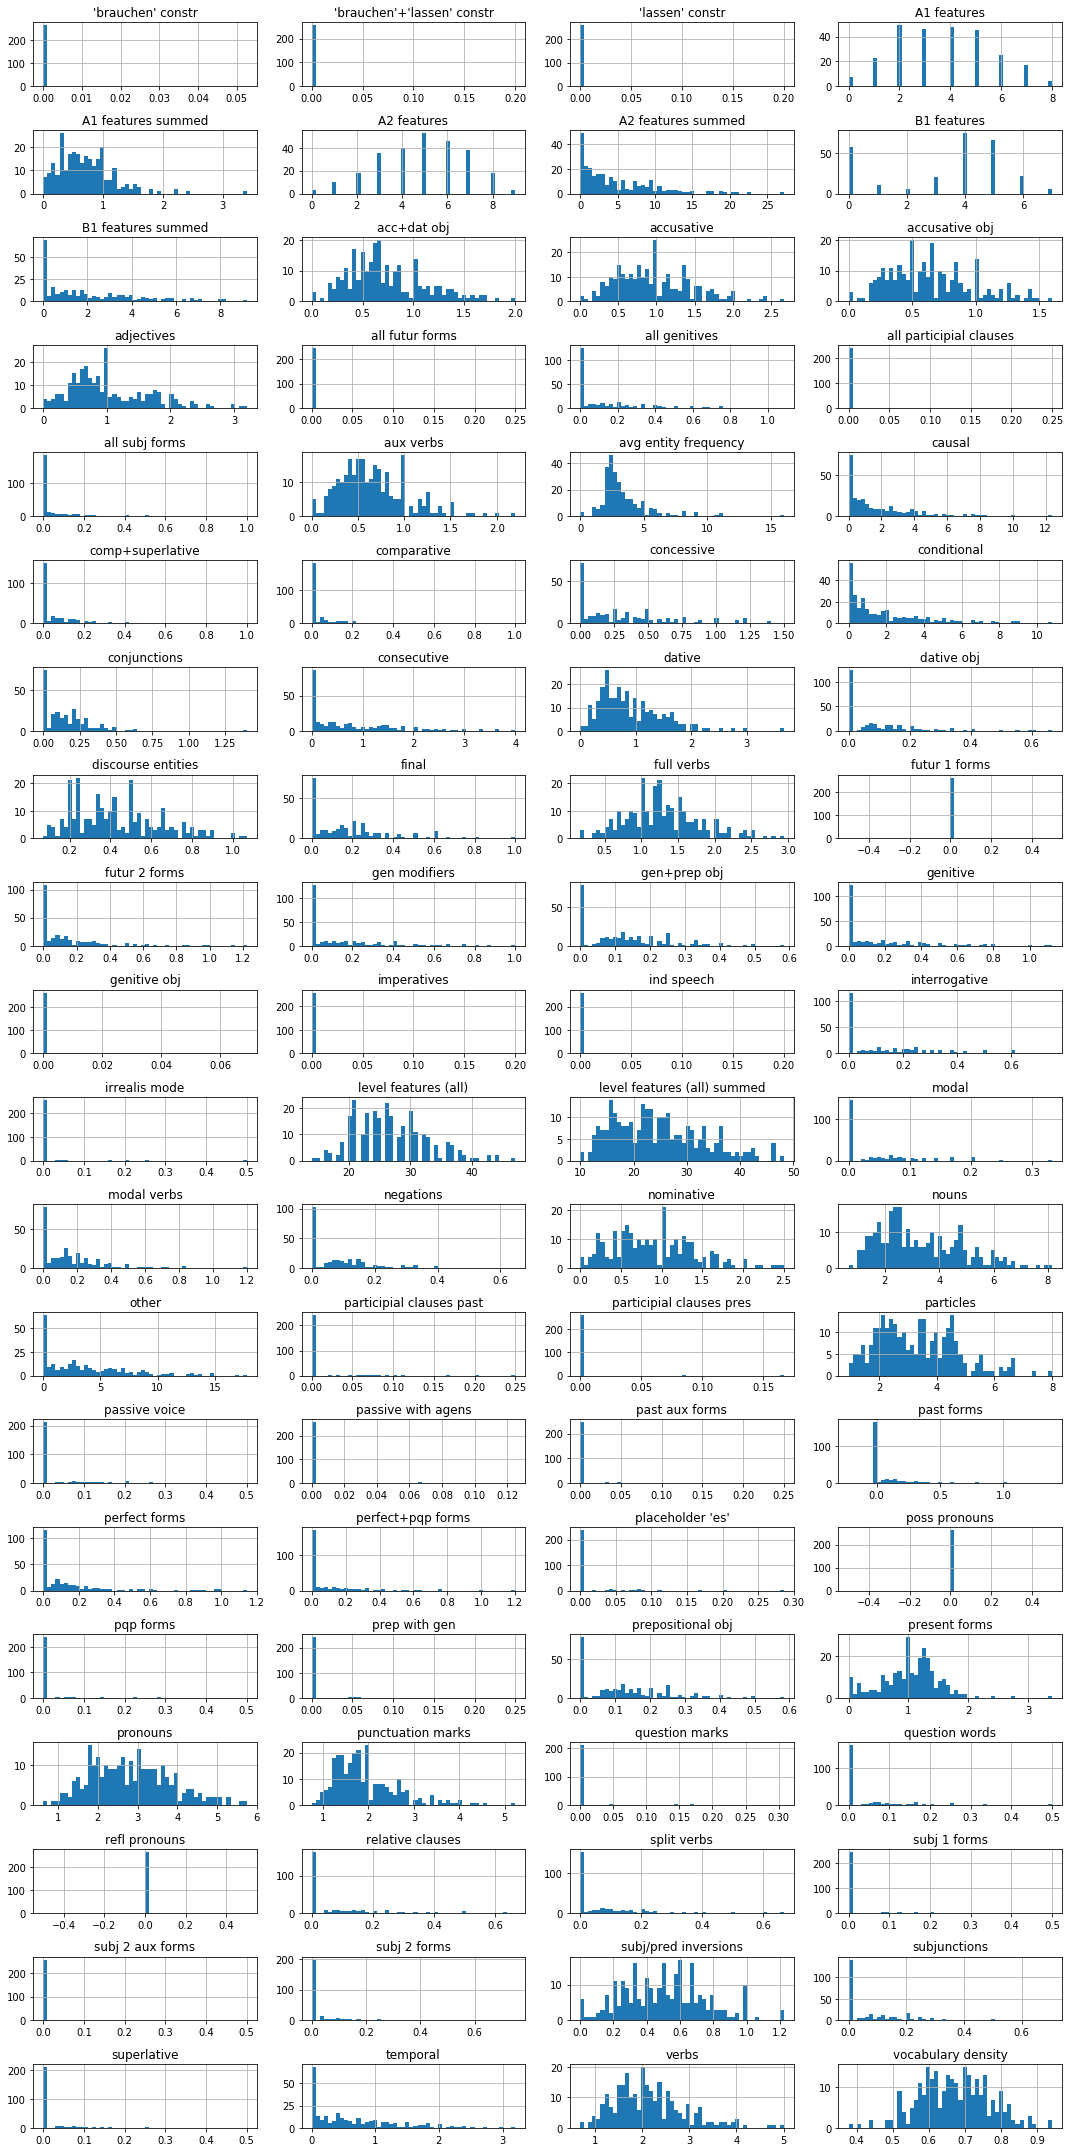

In [6]:
# Plot the histograms for the features 
dataset.hist(bins=50, figsize=(15,30), layout=(20,4))

# Save and plot
data_vis.save_fig("attribute_histogram_plots")
plt.show()

### Zero features

The histograms show that some features have only zeros values. Here we count how many features consist of only zeros (or near zeros). We find that possessive pronouns, reflexive pronouns and future 1 forms do not appear in any of the language level texts.

In [7]:
# Get mask for features with only zero values
mask = (np.isclose(dataset, 0.0)).all(axis=0)

# Get zero features
zero_features = dataset.loc[:, mask]

# How many/what zero features?
print("Number of zero features:  {}".format(zero_features.shape[1]))
print("Names of zero features:   {}".format(", ".join(list(zero_features.columns))))

Number of zero features:  3
Names of zero features:   poss pronouns, refl pronouns, futur 1 forms


### Feature scaling

We standardize the features by removing the mean and scaling to unit variance.

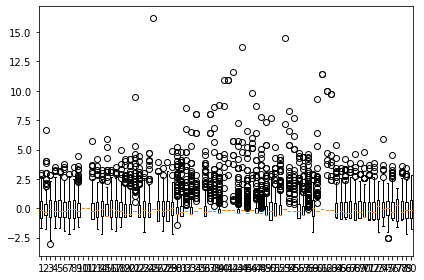

In [8]:
# Rename the feature array
features = dataset

# Scale features
scaler = sklearn.preprocessing.StandardScaler()
features = scaler.fit_transform(features)

# Plot and save features after scaling
plt.boxplot(features)
data_vis.save_fig("post_scaling")
plt.show()

### Principal Component Analysis

Here we perform a principal component analysis for our data. Later on we use the transformed features as a new feature set for classification.

PCA is by far the most common dimensionality reduction algorithm. It identifies the hyperplane that lies closes to the data and then projects the data onto it.

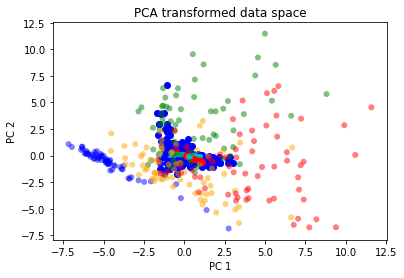

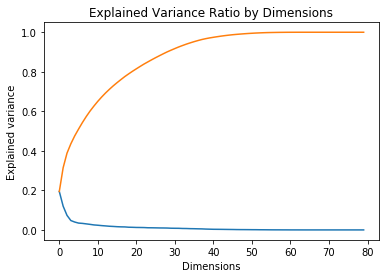

Number of features after PCA: 36


In [9]:
# Principal component analysis
pca = PCA()
pca_transformed = pca.fit_transform(features)

if dataset_name == "lang_levels":
    data_vis.plot_PCA(pca, pca_transformed, features, solutions)

# Get top components (with combined explained variance ratio of 95%)
pca_95 = PCA(n_components=0.95)
pca_reduced_features = pca_95.fit_transform(features)

print("Number of features after PCA: {}".format(pca_reduced_features.shape[1]))

## Training and Evaluating an SVM Classifier<a id='part2'></a>

[[back to top]](#top)

In this section, we will train and evaluate a linear SVM classifier using the linguistic features for language level analysis.

- We split the data into train, val and test set with similar label distributions
- We train a linear SVM classifier
- We evaluate on train and dev set and plot the confusion matrix
- We evaluate using cross-validation 
- We also perform hyper-parameter screening


### Split the data into train, val and test set

Split the data and make sure you each set contains a similar amount of samples for each label.

In [10]:
def get_train_val_test_split(features, solutions=None, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Split data (features) into train, validation/development 
    and test set according to given ratios. If solutions/labels are given, equally statify the among the classes.
    
    Parameters:
        
        features (numpy array) -- dataset features
        
    Keyword arguments:
    
        solutions (numpy array) -- dataset solutions, default=None
        train_ratio (float) -- relative size of training set, default = 80%
        val_ratio (float) -- relative size of validation set, default = 10        
        test_ratio (float) -- relatize size of test set, default = 10%
        
    Return:
    
        X_train (numpy array) -- features of training set
        X_val (numpy array) -- features of validation/develepment set
        X_test (numpy array) -- features of test set
        
        y_train (numpy array) -- labels of training set
        y_val (numpy array) -- labels of validation/development set
        y_test (numpy array)  -- labels of test set"""
    
    # Check whether ratios add up to 1.0
    ratio_sum = train_ratio + val_ratio + test_ratio
    
    # Raise error if ratios are set incorrectly
    if ratio_sum != 1.0:
        raise IOError("Train, val and test ratios have to sum up to 1.0.")
    

    # Split the data a first time into train and test set (= validation+test set)
    X_train, X_test, y_train, y_test = train_test_split(features, solutions,
                                                        train_size=train_ratio, stratify=solutions,
                                                        random_state=RANDOM_SEED, shuffle=True)

    # Set test size
    test_size = test_ratio/(test_ratio + val_ratio)

    # Split data (previous "test") a second time into validation and test set 
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=test_size, stratify=y_test, 
                                                    random_state=RANDOM_SEED, shuffle=True) 
    
    # Return all sets
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
# Get training, validation and test data
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test_split(features, solutions)

# Print size
print('Train size: {}'.format(y_train.shape[0]))
print('Val size: {}'.format(y_val.shape[0]))     
print('Test size: {}'.format(y_test.shape[0]))

# Print distribution of labels/classes among sets
print('\nLabel distributions\n********************')
print("\nTrain set:", np.unique(y_train,return_counts=True)[1]) 
print("Val set:  ", np.unique(y_val, return_counts=True)[1])
print("Test set: ", np.unique(y_test, return_counts=True)[1])

Train size: 211
Val size: 26
Test size: 27

Label distributions
********************

Train set: [49 50 59 53]
Val set:   [6 6 7 7]
Test set:  [7 6 8 6]


### Linear SVM Classifier

Initialize a linear SVM classifier and fit it using the training data.

In [12]:
# Set the classifier
classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=3000)

# Fit the data
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

### Evaluation

We evaluate the classifier on the training and validation data.
Accuracy is only one way of inspecting the performance of our system. We can also compute the confusion matrix and check which classes were predicted correctly and which were mixed up. For instance, B2 texts are sometimes confused as B1 texts.

Both accuracies and confusion matrices show that the classifier overfits the training data. Overfitting can be counteracted using the following methods:

- Adding more training data (not possible here)
- Cross-validation
- Adjust the regularization parameter C
- Dimensionality reduction 

In [13]:
# Predict the train and val set
pred_train = classifier.predict(X_train)
pred_val = classifier.predict(X_val)
pred_test = classifier.predict(X_test)

# Print Accuracies
print('Accuracy train: {}%'.format(np.round(sklearn.metrics.accuracy_score(y_train, pred_train)*100),2))
print('Accuracy val:   {}%'.format(np.round(sklearn.metrics.accuracy_score(y_val, pred_val)*100),2))
print('Accuracy test:   {}%'.format(np.round(sklearn.metrics.accuracy_score(y_test, pred_test)*100),2))

Accuracy train: 100.0%
Accuracy val:   88.0%
Accuracy test:   85.0%


### Confusion matrix

The confusion matrix shows the ground truths and prediction and lets find out which labels were often confused.

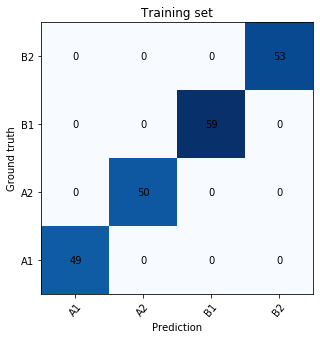

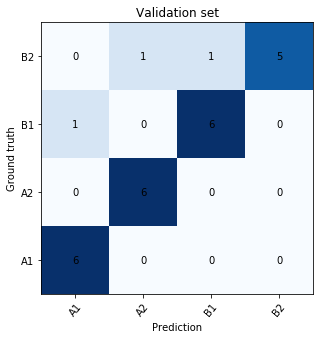

In [14]:
# Plot the confusion matrix for training set
data_vis.plot_confusion_matrix(y_train, pred_train, label_set, 'Training set')

# Plot the confusion matrix for validation set
data_vis.plot_confusion_matrix(y_val, pred_val, label_set, 'Validation set')

### Cross-Validation

Evaluating on one singe validation or test set can be problematic if the set is very small, as it is the case here. Different validation sets yield different performance scores, as we see above with 85% and 88%. 

Cross-validation uses different splits of the data as training and test data, which gives a more balanced evaluation. 

In [15]:
def cross_validation(classifier, features, solutions, hold_out_test_set=False, train_ratio=0.8,
                    n_split = 20):
    """Get performance scores for cross validation.
    
    Arguments:
    
        classifier (sklearn model) -- classifier/model to evaluate (does not have to be fitted)
        features (np.array) -- features for training
        solutions (np.array) -- correct labels
        
    Keyword arguments:
    
        hold_out_test_set (Boolean) -- whether or not to split data and hold out test set (default = False)
        train_ratio (float) -- ratio of training size (default = 0.8)
        n_split (int) -- number of cross validation splits

    Return:
        
        train_acc (float) -- mean accuracy on training sets 
        test_acc (float) -- mean accuracy on test sets
        scores (dict) --  dictionary with makro averaged precision, recall, acurracy and F1 score"""
    
    if dataset_name == 'lang_levels':
        n_splits = 50
    else:
        n_splits = 10
    
    # If test set has to be left untouched
    if hold_out_test_set:
        
        # Get train, dev and val split
        X_train, X_val, X_test, y_train, y_val, y_test = get_train_dev_test_split(features, solutions)

        # Concatenate train and val set for cross validation
        # EXCLUDE test set!
        X_train_val = np.concatenate([X_train, X_val])
        y_train_val = np.concatenate([y_train, y_val])
        
    # Otherwise use full feature set
    else:
        X_train_val = features
        y_train_val = solutions
        
    # Set metrics of interest
    scoring = {'precision_macro': 'precision_macro',
               'recall_macro': 'recall_macro',
               'accuracy': 'accuracy',
               'F1_macro':'f1_weighted' }
    
    # Set up cross validation splits
    cross_val = sklearn.model_selection.ShuffleSplit(n_splits=n_splits, train_size=0.8, 
                                           random_state=RANDOM_SEED)
    
    # Get accuracies over all cross validations
    scores = sklearn.model_selection.cross_validate(classifier, X_train_val, 
                                                    y_train_val, cv=cross_val, 
                                                    scoring=scoring, n_jobs=5,
                                                    return_train_score=True)
    
    # Get mean training and test accuracy
    train_acc = np.round(np.mean(scores["train_accuracy"]),4)
    test_acc = np.round(np.mean(scores["test_accuracy"]),4)

    # Return train/test accuracy and all collected scores
    return train_acc, test_acc, scores

In [16]:
# Merge train and val set for cross validation
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Get cross validation results
train_acc, test_acc, scores = cross_validation(classifier, X_train_val, y_train_val)

# Print accuracies
print('Training accuracy: {}'.format(train_acc))
print('Val accuracy: \t   {}'.format(test_acc))

Training accuracy: 1.0
Val accuracy: 	   0.8458


### Hyper-parameter screening

Since we clearly overfit the training data, it's a good idea to find a better value for the regularization parameter (*C*). **A smaller hyper-parameter *C* leads to a wider margin area but more margin violations**. 
We also optimize the tolerance for stopping criteria (*t*).


The hyper-parameter screening yields the optimal values and improves the accuracy by more than 1%.

In [17]:
# Import (warning ignoring)
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def parameter_screening(classifier, X_train, y_train, parameter_dict):
    """Find the best parameter settings for a given classifier using grid search. 
    
    Paramters:
        classifier (sklearn model) -- classifier/model (e.g. sklearn.svm._classes.LinearSVC)  
        parameter_dict (dict) -- dictionary containing parameters and values to screen
        
    Return:
        para_search.best_score_ (np.float) -- highest score achieved by Grid Search
        para_search.best_params_ (dict) -- parameters that yield highest score"""
    
    # Set up cross validation
    cross_val = sklearn.model_selection.ShuffleSplit(n_splits=50, train_size=0.8, 
                                                     random_state=RANDOM_SEED)
    
    # Find most suitable parameters using Grid Search
    para_search = sklearn.model_selection.GridSearchCV(classifier, parameter_dict, cv=cross_val)
    para_search.fit(X_train, y_train)
    
    # Return best score and its parameters
    return para_search.best_score_, para_search.best_params_

/home/jsuter/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
# Set a classifier
classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=2000)

# Get performance before hyper-parameter screening
train_acc, test_acc, scores = cross_validation(classifier, X_train_val, y_train_val)

# Printing results
print("Accuracy before parameter screening")
print('Training accuracy: {}'.format(train_acc))
print('Validation accuracy: \t   {}'.format(test_acc))

# Set ranges of paramters to screen
parameter_dict = {'C':   [0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
                  'tol': [0.0001, 0.001, 0.01, 0.1, 1.0]}

# Parameter screening to retrieve best hyper-paramters (C, tol)
best_score, best_params = parameter_screening(classifier, X_train_val, y_train_val, parameter_dict)

# Print best results
print('\nBest parameters:', best_params, '\n')

# Train new classifier with ideal hyper-parameters
classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=2000, 
                           C=best_params["C"], tol=best_params["tol"])

# # Get performance after hyper-parameter screening
train_acc, test_acc, scores = cross_validation(classifier, X_train_val, y_train_val)

# Printing results
print("Accuracy before parameter screening")
print('Training accuracy: \t{}'.format(train_acc))
print('Validation accuracy: \t{}'.format(test_acc))

Accuracy before parameter screening
Training accuracy: 1.0
Validation accuracy: 	   0.8458

Best parameters: {'C': 0.5, 'tol': 0.1} 

Accuracy before parameter screening
Training accuracy: 	0.9999
Validation accuracy: 	0.8521


### Problem

The SVM classifier is **highly overfitting** the training data. The large number of features (80) given the relatively small number of samples (264) reduces the performance of the algorithm, a problem commonly knowns as the **curse of dimensionality**. Sparse features further enhance this effect.

What can we do against it?

- Add more training data (not possible)
- Regularization 
- Dimensionality reduction

Dimensionality reduction using feature projection is a common method for counter-acting problems associated with high dimensionality. It transforms the data from the high-dimensional space to a space of fewer dimensions. Common techniques are PCA (Principal Component Analysis) or LDA (Linear Discriminant Analysis).

A lesser known method for reducing feature space is feature agglomeration by hierarchical clustering: similar features are merged, which reduces the feature space.

-----
## Feature Agglomeration<a id='agglo'></a>

[[back to top]](#top)

In this section, we will reduce the feature dimensionality by agglomerating a selection features.

- We identify a sets of weaker features
- We agglomerate these features into clusters
- We train and evaluate classifier with the set of unchanged strong features and the agglomerated features


---- 

Feature agglomeration is very similar to [agglomerative clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), which is used to build clusters of similar samples. For feature agglomeration we use the transformed data, so instead of samples we cluster similar features.

<a href="url"><img src="figures/dendrogram.png" width="600"></a>



**Agglomerative** indicates a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy. The **linkage** criteria determines the metric used for the merge strategy. We use the **Ward linkage**, which minimizes the sum of the squared differences within all clusters. It **minimizes the variance** of the clusters being merged. The **affinity** is the metric used to compute the linkage. For **Ward linkage** the only option is euclidean. We do not add a **connectivity** constraint as our features are not structured in a way that would benefit from it.


Here is an example for feature agglomeration of pixel features found on [scikit-learn](https://sklearn.org/auto_examples/cluster/plot_digits_agglomeration.html):


<a href="url"><img src="figures/f_agglo.png" width="400"></a>


### Only agglomerate weak features

Normally feature agglomeration is performed on the entire set of features. However, we do not want to reduce the effect of strong features and thus only agglomerate the weaker features, i.e. the sparse or less relevant features. Thus, we agglomerate the weak features and combine them with the strong features to achieve the highest performance.

### Identify sparse features

Here we identify sparse features or, in other words, the features that are zero for many samples and have a low variance. We consider all features that have a 0 value in more than one third of the samples as sparse. This method classifies **27 features as sparse - a third of all features**. 

In the  feature agglomeration process, those features are merged into 5 clusters. The original 27 features are discarded and the 5 new clustered features are included instead. Combined with the 27 non-sparse features, this yields a total of 32 features. This method counter-acts sparsity, reduces the number of features and mitigates the impact of noise. The feature agglomeration step led to an improvement in the classifier’s performance

In [19]:
# Reload unscaled features
features = np.array(dataset)

# Count how many times feature is empty
non_zeros_in_features = np.count_nonzero(features, axis=0)

# Get mask for features that are empty more than half the time
sparse_feature_mask = (non_zeros_in_features <= features.shape[0]*0.33)
non_sparse_feature_mask = np.invert(sparse_feature_mask)

# Get indices of sparse and non-sparse features
sparse_index = np.where(sparse_feature_mask)[0]
non_sparse_index = np.where(np.invert(sparse_feature_mask))[0]

# Scale the features
features = scaler.fit_transform(features)

# Get sparse and non-sparse features
sparse_features = features[:, sparse_index]
non_sparse_features = features[:, non_sparse_index]

# Get sparse and non-sparse features
sparse_f_names = feature_names[sparse_feature_mask]
non_sparse_f_names = feature_names[non_sparse_feature_mask]

# Print number of sparse and non-sparse features; print sum
print('Sparse features\n------------------')
print('Total features: {}'.format(sparse_index.shape[0] + non_sparse_index.shape[0]))
print('Sparse features: {}'.format(sparse_index.shape[0]))
print('Non-sparse features: {}'.format(non_sparse_index.shape[0]))
print()
print('Sparse feature names:')
print(sparse_f_names.tolist())

Sparse features
------------------
Total features: 80
Sparse features: 27
Non-sparse features: 53

Sparse feature names:
['poss pronouns', 'refl pronouns', 'prep with gen', 'genitive obj', 'pqp forms', 'past aux forms', 'futur 1 forms', 'all futur forms', 'subj 1 forms', 'subj 2 forms', 'subj 2 aux forms', 'ind speech', 'irrealis mode', 'all subj forms', 'imperatives', 'passive voice', 'passive with agens', 'comparative', 'superlative', 'participial clauses pres', 'participial clauses past', 'all participial clauses', 'question marks', "placeholder 'es'", "'brauchen' constr", "'lassen' constr", "'brauchen'+'lassen' constr"]


### Identify less relevant features

Sparsity does not necessarily make a feature irrelevant. The two sparse features *subjunctive 1 forms* and *genitives*, for example, are in the top 15 relevant features when looking at their coefficient strengths.

Linear support vector classifiers allow inspection of the **feature coefficients**. They show how much a feature contributes to the prediction of each class. The figure below shows the complete set of features sorted according to the strength of their coefficients: red indicates that a feature is considered a strong indicator for the class; blue means the feature works as a counter-indicator; white indicates that the feature is not informative for this class. 

*Modal clauses*, for instance, are considered strong indicators for B2 level texts, while they are unlikely to appear in B1 level texts. This could indicate that modal clauses are only learned at level B2.

Since only roughly the first 15 features show strong coefficients, we only consider those **15 features as relevant  features**. We consider all the other **65 features as less relevant features** (also called irrelevant features). We merge the 65 features using feature agglomeration and add the 5 resulting agglomerated features to the 15 relevant features.

Coefficients for feature "modal":
[[ 0.12486773]
 [-0.06303113]
 [-2.10748481]
 [ 1.45717812]]


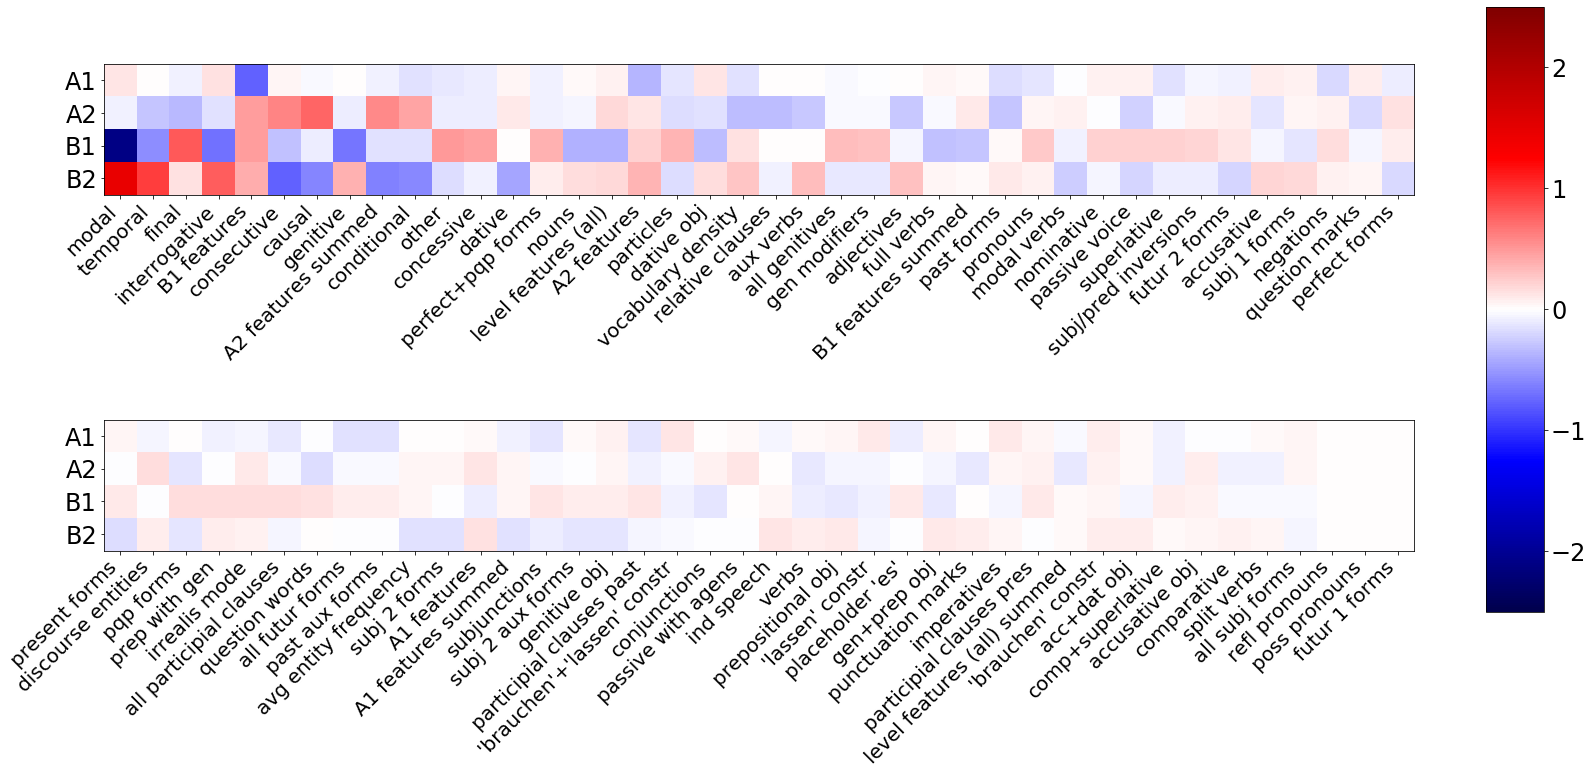

In [20]:
def get_sorted_coefficients(classifier, feature_names):
    """Get features and coefficients sorted by coeffience strength in Linear SVM.
    
    Parameter:
    
        classifier (sklearn.svm._classes.LinearSVC) -- linear SVM classifier (has to be fitted!)
        feature_names (list) -- feature names as list of strings
        
    Return:
    
        sort_idx (np.array) -- sorting array for features (feature with strongest coeffienct first)
        sorted_coef (np.array) -- sorted coefficient values
        sorted_fnames (list) -- feature names sorted by coefficient strength"""
    

    # Sort the feature indices according absolute coefficients (highest coefficient first)
    sort_idx = np.argsort(-abs(classifier.coef_).max(axis=0))

    # Get sorted coefficients and feature names
    sorted_coef = classifier.coef_[:,sort_idx]
    sorted_fnames = feature_names[sort_idx].tolist()

    return sort_idx, sorted_coef, sorted_fnames


# Fit a linar SVM
classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=2000, 
                           C=best_params["C"], tol=best_params["tol"])
classifier.fit(X_train, y_train)

# Coefficients for example feature "modal"
print('Coefficients for feature "modal":')
print(classifier.coef_[:, feature_names == 'modal'])

# Get feature indices sorted by coefficient strength
sort_idx,_,_ = get_sorted_coefficients(classifier, feature_names)

# Plot the classifier's coefficients for each feature and label
plt = data_vis.plot_feature_coefficients(classifier, feature_names, label_set)

In [21]:
# Set number of relevant features
N_REL_FEATURES = 15

# Less-rel features and names
less_relevant_features = features[:,sort_idx[N_REL_FEATURES:]]
less_relevant_f_names  = feature_names[sort_idx[N_REL_FEATURES:]]    

# Relevant features and names
relevant_features = features[:,sort_idx[:N_REL_FEATURES]]   
relevant_f_names  = feature_names[sort_idx[:N_REL_FEATURES]]

# Check number of features
assert less_relevant_features.shape[1] == features.shape[1] - N_REL_FEATURES
assert relevant_features.shape[1] == N_REL_FEATURES

### Feature Agglomeration


After identifying sets of feature to be agglomerated, we merge them using feature agglomeration. We use 5 feature clusters, meaning that feature agglomeration returns five agglomerated features.


In [22]:
def feature_agglomeration(n_clusters, agglo_features, agglo_f_names):
    """Reduce the feature space by agglomerating the given agglo_features to a specific number (n_clusters)
    using feature agglomeration.
     
    Parameters:       
    
        n_clusters (int) -- number of clusters for feature agglomeration
        agglo_features (np.array) -- features to agglomerate
        agglo_f_names (list) -- feature names for agglo_features
                 
    Return:
        agglomerated_features (np.array) -- combined array with agglomerated and keep features
        agglomerated_f_names (np.array) -- feature names for reduced features"""
        
    
    # How to compute feature clusters with feature agglomeration
    agglo_cluster = sklearn.cluster.FeatureAgglomeration(n_clusters=n_clusters, affinity="euclidean",
                                                   linkage="ward", connectivity=None,
                                                   pooling_func=np.mean)

    # Fit data
    agglo_cluster.fit(agglo_features)
    
    # Get agglomerated feature set
    agglomerated_features = agglo_cluster.transform(agglo_features)

    # Get labels
    labels = agglo_cluster.labels_
    
    # Sort the label indices
    sorted_label_idx = np.argsort(labels)
    
    # Get sorted cluster components
    cluster_components = labels[sorted_label_idx]
    
    # Sort the feature names by cluster
    sorted_agglo_f_names = agglo_f_names[sorted_label_idx]
    
    # Plot feature clusters
    data_vis.plot_cluster_components(cluster_components, sorted_agglo_f_names)
    
    # Agglomerated feature names
    agglomerated_names = ["cluster_"+(str(i+1)) for i in range(n_clusters)]
    
    # Check number of features and clusters
    assert agglomerated_features.shape[1] == n_clusters
    
    # Return agglomerated features and feature names
    return agglomerated_features, agglomerated_names

### Feature Sets

We have divided our features into sparse and non-sparse features as well as into relevant and less relevant features. We have also reduced the features using feature agglomeration. Those agglomerated features of weaker features can be combined with the stronger features. Since we also want to compare the newly created feature sets with the original features and the baseline, this leaves us with a large number of differnet feature sets to test.

In order not to lose track of the different feature set and for easier comparison, we implemented widget which lets you select the desire feature set.

- original features
- original agglomerated features
- baseline features
- PCA components

- only non-sparse features
- only relevant features
- only sparse features
- only less relevant features

- only agglomerated sparse features
- only agglomerated less relevant features

- agglomerated sparse features + non-sparse features
- agglomerated less relevant features + relevant features

When selecting a feature set, the desired feature set is automatically generated. If necessary, feature agglomeration is executed. The performance is immediately evaluated using cross-evaluation.



In [23]:
def generate_feature_set(feature_set, n_clusters=5):
    """Generate the feature set of choice. Some feature sets agglomerate weaker features 
    and/or combine them with strong features.
    
    Parameters:
        feature_set (string) -- feature set to compute
        
    Keyword arguments:
        n_clusters (int) -- number of clusters for feature agglomeration
        
    Return:
        feature set of choice (np.array)"""
    
    
    if feature_set == "original features":
        return features      
    
    elif feature_set == "only relevant features":
        return relevant_features
    
    elif feature_set == "baseline features":
        return baseline_features
    
    elif feature_set == "PCA components (explained variance of 95%)":
        return pca_reduced_features
    
    elif feature_set == "only less relevant features":
        return less_relevant_features
    
    elif feature_set == "only sparse features":
        return sparse_features
    
    elif feature_set == "only non-sparse features":
        return non_sparse_features
    
    elif feature_set == "original agglomerated features":
        
        # Get agglomerated original features
        agglomerated_features, agglomerated_f_names = feature_agglomeration(n_clusters, 
                                                                            features, feature_names)      
            
        return agglomerated_features
    
    elif feature_set == "only agglomerated sparse features":
        
        # Get agglomerated sparse features
        agglomerated_features, agglomerated_f_names = feature_agglomeration(n_clusters, 
                                                                            sparse_features, sparse_f_names)
        
        return agglomerated_features
    
    
    elif feature_set == "only agglomerated less relevant features":
        
        # Get agglomerated less relevant features
        agglomerated_features, agglomerated_f_names = feature_agglomeration(n_clusters, 
                                                                            less_relevant_features, 
                                                                            less_relevant_f_names)
        
        return agglomerated_features
    
    
    elif feature_set == "agglomerated sparse features + non-sprase features":
            
        # Get agglomerated for sparse features
        agglomerated_features, agglomerated_f_names = feature_agglomeration(n_clusters, 
                                                                            sparse_features, sparse_f_names)
        # Combine agglomerated sparse + non-sparse features
        combined_features = np.concatenate([agglomerated_features, non_sparse_features], axis=1)
        
        return combined_features
    
    elif feature_set == "agglomerated less relevant features + relevant features":
        agglomerated_features, agglomerated_f_names = feature_agglomeration(n_clusters, 
                                                                            less_relevant_features, 
                                                                            less_relevant_f_names)

        # Combine agglomerated less relevant + relevant features
        combined_features = np.concatenate([agglomerated_features, relevant_features], axis=1)
        
        return combined_features
    
    else:
        # In case unkown feature set is given
        raise NotImplementedError("Unknown feature set: {}".format(feature_set))
        return None    

In [24]:
def evaluate_feature_set(new_features, solutions, svm_parameters=None):
    """
    Evaluate (and generate) the feature set of choice using cross-validation.
    
    Parameters:
        new_features (string) -- feature set of choice
        soltutions (np.array) -- labels/solutions for features
        svm_parameters (dict) -- linear SVM parameters (default=None)
        
    Return: None"""
        
    # Get training, validation and test data
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test_split(new_features, solutions)

    X_train_val = np.concatenate([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])
    
    # If no svm parameters available, use default
    if svm_parameters is None:
        
        # Define a classifier with default values
        classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=2000)
    else:
        # Define a classifier with screened svm parameters
        classifier = svm.LinearSVC(random_state=RANDOM_SEED, max_iter=2000, C=svm_parameters["C"],
                                  tol=svm_parameters["tol"])
        
        svm.LinearSVC(ConvergenceWarning)
        
    # Get performance before hyper-parameter screening
    train_acc, test_acc, scores = cross_validation(classifier, X_train_val, y_train_val)
    
    print("\n\nOriginal number of features: {}".format(features.shape[1]))
    print("New number of features: {}".format(new_features.shape[1]))

    # Printing results
    print("\nPerformance\n*************")
    print('Training accuracy: {}'.format(train_acc))
    print('Val accuracy: \t   {}'.format(test_acc))

In [25]:
# Widget interaction
@interact(feature_set=data_vis.feature_set_widi, n_clusters=data_vis.n_cluster_widi)
def generate_and_evaluate_feature_set(feature_set, n_clusters):
    """Generate and evaluate feature set of choice. 
    Widget interaction decorator calls function each sample different feature set 
    or number of cluster is selected.
    
    Parameters:
        new_features (string) -- feature set of choice
        n_clusters (int) -- number of clusters for feature agglomeration
        
    Return: None"""    
    
    # Get the features for the respective feature set
    features = generate_feature_set(feature_set, n_clusters)
    
    # Re-scale the features
    features = scaler.fit_transform(features)
    
    # Evaluate the new feature set
    evaluate_feature_set(features, solutions, best_params)

interactive(children=(Select(description='Feature set', index=11, layout=Layout(align_items='stretch', border=…

## Results and Discussion<a id='disc'></a>

[[back to top]](#top)

### Main insights
In the table below, we collect the results for all different feature sets. <br>
The **original features** yield an accuracy of **85.21%**, which outperforms the baseline by far and shows that a linear SVM classifier trained on linguistic features can be used to classify language levels.

**Feature agglomeration of weaker features** clearly improves performance. Agglomerating the sparse features and combining them with the non-sparse features slightly increases accuracy to 89.96%. Selecting the 15 most relevant features using the coefficient strengths and agglomerating the less relevant features results in an **increase of 7%**, yielding an accuracy of **92.79%**.

One could also simply discard the sparse or less relevant features but our experiments show that adding the agglomerated features to the non-sparse or relevant features slightly improves the performancy by roughly 1% when comparing to the non-sparse or relevant features alone. Therefore, the sparse and less relevant features can **contribute to the classifier when preprocessed through feature agglomeration**.

We also show that **selecting weak features using the coefficient strengths** is a very suitable method for selecting features that could benefit from feature agglomeration. The feature set with the agglomerated relevant features achieves the highest results, **outperforming the sparse/non-sparse feature set by 3%**. The less relevant features also clearly outperform the baseline while the sparse features do not.

| Feature set | # Features | Training Accuracy | Validation Accuracy |
| --- | --- | --- | --- |
| Original | 80 | 99.99% | **85.21%** | 
| Baseline | 2 | 51.11% |  **48.38%** |
| | | |
|Non-sparse features | 53|  99.93% | **88.33%**|
|Sparse features | 27 | 59.19% | **42.88%**|
|Relevant features | 15 | 95.92% | **91.96%**|
|Less relevant features | 65 | 97.14% | **73.38%**|
| | | |
|Agglomerated original features | 5 | 78.60% | **74.96%**|
|Agglomerated sparse features | 5 | 40.47% | **31.54%**|
|Agglomerated less relevant features | 5 | 56.12% | **50.29%**|
||||
| PCA components (explained variance of 95%) | 36 | 96.42% | **76.00%** |
| | | |
|Agglomerated sparse + non-sparse features | 58 | 99.95% | **89.96%**|
|Agglomerated less relevant + relevant features | 20 | 97.93% | **92.79%**|


For the full analysis, please read the report [here](https://github.com/athrado/lang-level/tree/master/4_Reports).

## Conclusion

- Feature agglomeration on a select set of features can considerably improve performance
- Coefficient strengths are good indicators for selecting relevant features
- Concatenating strong and agglomerated weak features reduces overfitting while preserving high accuracy

## Take Home Poem


<br>

```
Linguistic features everywhere,
about domain they do not care,
perform just fine on any type
of text, no matter who does write.

Sev'ral, though, are oh! so rare,
just won't occur, to our despair!
While others shine just like a hero,
they often simply show a zero.

Those troublemakers are a threat,
overfit our training set!
Shall we discard those features, then?
Or could there be a better plan?

Why not let birds of a feather,
share a feature space together.
Reduce dimensions and you'll get
a nice and smaller feature set.

Combine them now with features strong,
and - hey, look there! - they get along!
They help each other and then beat
the orig'nal model, ain't that neat?

```
